# Final Results for Publication
No recalculation of results = Depends on tcf_results_sandbox (pickle dump)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset, InsetPosition

from scipy import interpolate

import chirpy as cp

cp.visualise.pubplot.source_params(matplotlib)
assert cp.config.version_info() >= (0, 25, 3), 'Please get a recent version of ChirPy!'
cp.config.set_pal_n_cores(4)
cp.config.set_verbose(True)

/tmp/ipykernel_349684/661001457.py:13: ChirPyWarning: __pal_n_cores__ set to 4
  cp.config.set_pal_n_cores(4)


In [2]:
class JOB():
    def __init__(self, jobname, range=(0, 1, -1), ts_fs=0.5):
        try:
            self.system = cp.system.Supercell(DIR + jobname + 'md-pos-1.xyz', DIR + jobname + 'md-vel-1.xyz', fn_topo=DIR + 'w0128-09965-300_topology.pdb', range=range)    
        except FileNotFoundError:
            self.system = cp.system.Supercell(DIR + jobname + 'md-pos-1.xyz.bz2', DIR + jobname + 'md-vel-1.xyz.bz2', fn_topo=DIR + 'w0128-09965-300_topology.pdb', range=range)    
        self.ts_fs = ts_fs
        self.ts_au = ts_fs * cp.constants.t_fs2au

    def extract_velocities(self):
    # --- expand iterator (would be cool if correlate() would work directly on iterator or batches)
        vel_au, pos_aa = zip(*[(self.system.XYZ.vel_au, self.system.XYZ.pos_aa) for _fr in self.system.XYZ])
        self.pos_aa = np.array(pos_aa)        
        self.vel_au = np.array(vel_au)
        self.masses_amu = self.system.XYZ.masses_amu
        self.symbols = np.array(self.system.XYZ.symbols)

        # --- get COM velocities
        self.mol_map = self.system.mol_map
        mv = np.array(cp.mapping.dec(self.vel_au, self.mol_map, axis=1))  # split vel into mol
        mp = np.array(cp.mapping.dec(self.pos_aa, self.mol_map, axis=1))  # split vel into mol
        mm = np.array(cp.mapping.dec(self.masses_amu, self.mol_map, axis=0))  # split mass into mol
        self.com_masses_amu = mm.sum(axis=-1)
        self.com_vel_au = np.moveaxis((mv * mm[:, None, :, None]).sum(axis=-2) / self.com_masses_amu[:, None, None], 0, 1)
        # --- we assume unbroken molecules
        self.com_pos_aa = np.moveaxis((mp * mm[:, None, :, None]).sum(axis=-2) / self.com_masses_amu[:, None, None], 0, 1)

        # ---- ALTERNATIVE: take the O, works very well but H-noise in the VACF
        # self.com_vel_au = self.vel_au[:, self.symbols == 'O']
        # self.com_pos_aa = self.pos_aa[:, self.symbols == 'O']
        
        del self.system, self.pos_aa, mm, mv, mp

    def get_power_spectrum(self, window_length_au=None, T_K=300):
        n_frames, n_atoms, n_dims = self.vel_au.shape
        wgh = np.repeat(self.masses_amu, n_dims) * cp.constants.m_amu_au

        P_args = dict(
            ts=self.ts_au,
            window_length=window_length_au,
            n_cores=4,
            adjusted_signal_length=None,  # zero pad or trim if necessary, does not change quality in high-freq TCF
            finite_size_correction=True,
            symmetry='even',
        )
        
        PROC = cp.core.PALARRAY(cp.physics.statistical_mechanics.spectral_density,
                    self.vel_au.reshape(n_frames, -1).T,
                    **P_args
                    )
        
        f, S, R = zip(*PROC.run())
        self.P = {}      
        self.P['freq'] = f[0]
        self.P['power'] = np.mean(np.array(S) * wgh[:, None], axis=0)   
        self.P['tcf_power'] = np.mean(np.array(R), axis=0)  
        self.P['effective_mass'] = cp.constants.k_B_au * T_K / (np.array(S).sum(axis=-1) * 2*np.pi / n_frames / self.ts_au) / wgh

        
        # ---- P com ------------
        n_frames, n_mols, n_dims = self.com_vel_au.shape
        wgh = np.repeat(self.com_masses_amu, n_dims) * cp.constants.m_amu_au
        
        PROC = cp.core.PALARRAY(cp.physics.statistical_mechanics.spectral_density,
                    self.com_vel_au.reshape(n_frames, -1).T,
                    **P_args
                    )
        
        f, S, R = zip(*PROC.run())
        self.P_com = {}      
        self.P_com['freq'] = f[0]
        self.P_com['power'] = np.mean(np.array(S) * wgh[:, None], axis=0)   
        self.P_com['tcf_power'] = np.mean(np.array(R), axis=0)  
        self.P_com['effective_mass'] = cp.constants.k_B_au * T_K / (np.array(S).sum(axis=-1) * 2*np.pi / n_frames / self.ts_au) / wgh   


        # ----------------------
        self.window_length_au = window_length_au

    def _func(self, tau, data=None):
        n_frames, n_mols, n_dims = data.shape
        return ((data[:-tau] - data[tau:])**2).sum() / (n_frames - tau) / n_mols
            
    def get_mean_squared_displacement(self, sparse):
        import copy
        # ---------- needs parallelization
        import tqdm
        # sparse   # we do not need the high resolution of the VACF the linear regression
        positions = copy.deepcopy(self.com_pos_aa[::sparse]) # -- extract data first with copy to avoid expensive indexing
        n_frames, n_mols, n_dims = positions.shape

        # # this is super slow for some reason
        # PROC = cp.core.PALARRAY(self._func,
        #             np.arange(1, n_frames),
        #             n_cores=1,
        #             data=copy.deepcopy(self.com_pos_aa[::sparse]),
        #             )  
        # self.msd_aa2 = PROC.run().sum(axis=0)
        
        # -- very slow
        self.msd_aa2 = np.array([0.,] + [((positions[:-_tau] - positions[_tau:])**2).sum()/(n_frames-_tau)/n_mols for _tau in tqdm.tqdm(range(1, n_frames), desc='mean squared displacement')])
        # -- even slower
        # self.msd_aa2 = np.array([((self.com_pos_aa - np.roll(self.com_pos_aa, -_tau, axis=0))**2)[:-_tau].sum()/(n_frames-_tau)/n_mols for _tau in tqdm.tqdm(range(0, n_frames), desc='mean squared displacement')])

In [3]:
# --- ADJUST TO CORRECT DATA PATH
DIR = 'DATA/'
JOBS = [
    'w0128-09965-300.0-1.nve.xTB/',
    'w0128-09965-300.0-2.nve.xTB/',
    'w0128-09965-300.0-3.nve.xTB/',
    'w0128-09965-300.0-4.nve.xTB/',
    'w0128-09965-300.0-5.nve.xTB/',
    'w0128-09965-300.0-1.nvt_csvr_global_0001fs.xTB/',
    'w0128-09965-300.0-2.nvt_csvr_global_0001fs.xTB/',
    'w0128-09965-300.0-3.nvt_csvr_global_0001fs.xTB/',
    'w0128-09965-300.0-4.nvt_csvr_global_0001fs.xTB/',
    'w0128-09965-300.0-5.nvt_csvr_global_0001fs.xTB/',
    'w0128-09965-300.0-1.nvt_csvr_global_0010fs.xTB/',
    'w0128-09965-300.0-2.nvt_csvr_global_0010fs.xTB/',
    'w0128-09965-300.0-3.nvt_csvr_global_0010fs.xTB/',
    'w0128-09965-300.0-4.nvt_csvr_global_0010fs.xTB/',
    'w0128-09965-300.0-5.nvt_csvr_global_0010fs.xTB/',
    'w0128-09965-300.0-1.nvt_csvr_global_0100fs.xTB/',
    'w0128-09965-300.0-2.nvt_csvr_global_0100fs.xTB/',
    'w0128-09965-300.0-3.nvt_csvr_global_0100fs.xTB/',
    'w0128-09965-300.0-4.nvt_csvr_global_0100fs.xTB/',
    'w0128-09965-300.0-5.nvt_csvr_global_0100fs.xTB/',
    'w0128-09965-300.0-1.nvt_csvr_global_1000fs.xTB/',
    'w0128-09965-300.0-2.nvt_csvr_global_1000fs.xTB/',
    'w0128-09965-300.0-3.nvt_csvr_global_1000fs.xTB/',
    'w0128-09965-300.0-4.nvt_csvr_global_1000fs.xTB/',
    'w0128-09965-300.0-5.nvt_csvr_global_1000fs.xTB/',
    'w0128-09965-300.0-1.nvt_csvr_massive_0001fs.xTB/',
    'w0128-09965-300.0-2.nvt_csvr_massive_0001fs.xTB/',
    'w0128-09965-300.0-3.nvt_csvr_massive_0001fs.xTB/',
    'w0128-09965-300.0-4.nvt_csvr_massive_0001fs.xTB/',
    'w0128-09965-300.0-5.nvt_csvr_massive_0001fs.xTB/',
    'w0128-09965-300.0-1.nvt_csvr_massive_0010fs.xTB/',
    'w0128-09965-300.0-2.nvt_csvr_massive_0010fs.xTB/',
    'w0128-09965-300.0-3.nvt_csvr_massive_0010fs.xTB/',
    'w0128-09965-300.0-4.nvt_csvr_massive_0010fs.xTB/',
    'w0128-09965-300.0-5.nvt_csvr_massive_0010fs.xTB/',
    'w0128-09965-300.0-1.nvt_csvr_massive_0100fs.xTB/',
    'w0128-09965-300.0-2.nvt_csvr_massive_0100fs.xTB/',
    'w0128-09965-300.0-3.nvt_csvr_massive_0100fs.xTB/',
    'w0128-09965-300.0-4.nvt_csvr_massive_0100fs.xTB/',
    'w0128-09965-300.0-5.nvt_csvr_massive_0100fs.xTB/',
    'w0128-09965-300.0-1.nvt_csvr_massive_1000fs.xTB/',
    'w0128-09965-300.0-2.nvt_csvr_massive_1000fs.xTB/',
    'w0128-09965-300.0-3.nvt_csvr_massive_1000fs.xTB/',
    'w0128-09965-300.0-4.nvt_csvr_massive_1000fs.xTB/',
    'w0128-09965-300.0-5.nvt_csvr_massive_1000fs.xTB/',      
]

In [4]:
import pickle 

ds = 1 # 2 is sufficient, 8 is good for showing
frames = 50000
msd_ds = 8

T_K_nve = [297.8, 308.6, 306.3, 303.8, 290.4] # for back-scaling if desired

try:
    with open(f'DATA/w0128-09965-300.xTB_(0,{ds},{frames}).pkl', 'rb') as f:
        DATA = pickle.load(f)
        
except FileNotFoundError:
    DATA = {}
    for _job in JOBS:
        if 'nve' in _job:
            T_K = 300 # 297.7
        else:
            T_K = 300
        print(_job)    
        DATA[_job] = JOB(_job, range=(0, ds, frames) , ts_fs=0.5*ds)
        DATA[_job].extract_velocities()
        # DATA[_job].get_power_spectrum(window_length_au=None, T_K=T_K) # window_length_au = 20 * 1000 * cp.constants.t_fs2au 
        
        DATA[_job].get_power_spectrum(window_length_au=None, T_K=T_K) # window_length_au = 20 * 1000 * cp.constants.t_fs2au 
        del DATA[_job].vel_au, DATA[_job].com_vel_au, 

        DATA[_job].get_mean_squared_displacement(sparse=msd_ds//ds)  # the implementation is very time-consuming
        del DATA[_job].com_pos_aa  # safe memory

    # --- UNCOMMENT to store on disk
    if ds <= 4 and frames > 25000:
        with open(f'DATA/NEW_w0128-09965-300.xTB_(0,{ds},{frames}).pkl', 'wb') as f:
            pickle.dump(DATA, f)
        
print('Done')

Done


In [5]:
def Fourier_filter(signal, t_ps, f_start_rcm, f_end_rcm):
    n = len(t_ps)
    _ome = np.fft.rfftfreq(n=n, d=t_ps[1]*1000*cp.constants.t_fs2au) / cp.constants.t_au * cp.constants.E_Hz2cm_1
    ind = (_ome >= f_start_rcm) * (_ome <= f_end_rcm)

    F_sig = np.fft.rfft(signal, n=n, axis=0)
    F_sig[~ind] *= 0.

    return np.fft.irfft(F_sig, n=n, axis=0)


In [6]:
def make_plot_0(ax):
    ''' VACF '''
    
    n_frames = len(DATA['w0128-09965-300.0-1.nve.xTB/'].P['tcf_power'])
    t_ps = np.arange(n_frames) * DATA['w0128-09965-300.0-1.nve.xTB/'].ts_fs/1000
    t_ps_i = np.arange(4*n_frames-4) * DATA['w0128-09965-300.0-1.nve.xTB/'].ts_fs/1000/4
    
    ax.set_xlabel("time in ps", fontsize=14)
    ax.set_ylabel("VACF",fontsize=14)
    ax.tick_params(axis="both",which="major",labelsize=14)
    ax.set_xlim(-0, 1)
    ax.set_xscale('symlog', linthresh=0.1)
    
    xticks = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Adjust based on your preferred granularity
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(x) if x in [0.1, 1.0] else '' for x in xticks ])
    
    # -- ideally damped with tau
    X = t_ps #np.linspace(0, 1.1, 1000)
   
    tau = 0.1
    Y = np.exp(-X/tau)
    ax.fill_between(X, -Y, Y, color='k', alpha=0.05, zorder=-10000)
    
    tau = 0.01
    Y = np.exp(-X/tau)
    ax.fill_between(X, -Y, Y, color='k', alpha=0.05, zorder=-10000)
    
    # -- inset plot 0
    axins = ax.inset_axes([0.05, 0.75, 0.3, 0.22])
    axins.set_xlim(0.0075, 0.0105)
    axins.set_ylim(0.55, 0.62)
    # axins.set_xlim(0.0174, 0.020)
    # axins.set_ylim(0.42, 0.50)
    axins.set_xscale('symlog', linthresh=0.1)
    axins.set_xticks([])
    axins.set_yticks([])
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='0.75')
    
    # -- inset plot 1
    axins1 = ax.inset_axes([0.55, 0.39, 0.3, 0.22])
    axins1.set_xlim(0.091, 0.0955)
    axins1.set_ylim(0.1, 0.18)
    axins1.set_xscale('symlog', linthresh=0.1)
    axins1.set_xticks([])
    axins1.set_yticks([])
    mark_inset(ax, axins1, loc1=2, loc2=4, fc="none", ec='0.75')
    
    for _job, _color, _style, _label in zip(
        (
         'w0128-09965-300.0-%d.nve.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_global_0001fs.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_global_0010fs.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_global_0100fs.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_global_1000fs.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_massive_0001fs.xTB/', 
         'w0128-09965-300.0-%d.nvt_csvr_massive_0010fs.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_massive_0100fs.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_massive_1000fs.xTB/',  
        ),
        ('#000000', '#FF8C00', '#D32F2F', '#800080', '#00509E', '#FF8C00', '#D32F2F', '#800080', '#00509E'),
        ('--', '--', '--', '--', '--', '-', '-', '-', '-'),
        ('NVE', r'VR $\tau$=0.001 ps', r'VR $\tau$=0.01 ps', r'VR $\tau$=0.1 ps', r'VR $\tau$=1 ps', r'SD $\tau$=0.001 ps', r'SD $\tau$=0.01 ps', r'SD $\tau$=0.1 ps', r'SD $\tau$=1 ps'),
    ):
        
        VACF = np.mean([DATA[_job%_s].P['tcf_power'] / DATA[_job%_s].P['tcf_power'][0] for _s in range(1,6)], axis=0)
        VACF_std = np.std([DATA[_job%_s].P['tcf_power'] / DATA[_job%_s].P['tcf_power'][0] for _s in range(1,6)], axis=0)
        
        ax.plot(t_ps, (VACF), label=_label, color=_color, linestyle=_style, linewidth=1)
        axins.plot(t_ps_i, interpolate.interp1d(t_ps, VACF, kind='cubic')(t_ps_i), label=_label, color=_color, linestyle=_style, linewidth=1)
        axins1.plot(t_ps_i, interpolate.interp1d(t_ps, VACF, kind='cubic')(t_ps_i), label=_label, color=_color, linestyle=_style, linewidth=1)
    
        _value = np.sum([DATA[_job%_s].P['tcf_power'] for _s in range(1,6)], axis=0)
        _reference = np.sum([DATA['w0128-09965-300.0-%d.nve.xTB/'%_s].P['tcf_power'] for _s in range(1,6)], axis=0)
        # --- PRINT REL ERROR
        # print(_job,  (np.sum(np.abs(_value)) - np.sum(np.abs(_reference))) / (np.sum(np.abs(_reference))))
    
    _job = 'w0128-09965-300.0-%d.nve.xTB/'
    VACF = np.mean([DATA[_job%_s].P['tcf_power'] / DATA[_job%_s].P['tcf_power'][0] for _s in range(1,6)], axis=0)

    ax.set_ylim(-0.45, 1.05)
    ax.legend(loc="upper right", fontsize=10, ncol=2, borderpad=0.3,handletextpad=0.3,handlelength=0.8)
    ax.text(0.0005, -0.4, '0.01', size=8, color='0.6')
    ax.text(0.08, -0.4, '0.1', size=8, color='0.6')

In [7]:
def make_plot_1(ax):
    ''' Power Spectrum '''
    from scipy.ndimage import gaussian_filter1d
    
    n_frames = len(DATA['w0128-09965-300.0-1.nve.xTB/'].P['tcf_power'])
    OME = DATA['w0128-09965-300.0-1.nve.xTB/'].P['freq'] * cp.constants.E_aufreq2cm_1  
    # old wrong conversion
    # POW_au2kJpermol = cp.constants.E_au2J * cp.constants.avog / csp.constants.kilo
    
    # true density in E / ṽ 
    # factor 2 pi inverts normalisation from chirpy's spectral_density
    # factor 2 because we replace limits of symmetric integral -infty,infty with 0,infty, project POW on |w|
    corr = 2 * np.pi * 2 
    dw = 1  / n_frames / (ds*0.5*cp.constants.t_fs2au)  * cp.constants.E_aufreq2cm_1 
    beta = 1 / (cp.constants.k_B_au * 300)
    # per wavenumber
    POW_au2dm = 1000 * corr * beta / cp.constants.E_aufreq2cm_1 #* dw  # last factor only if we integrate over w_au
    
    ax.set_xlabel(r'$|\tilde\nu|$ in cm$^{-1}$', fontsize=14)
    ax.set_ylabel('vDOS in $10^{-3}$ states / cm$^{-1}$', fontsize=14)
    ax.tick_params(axis="both",which="major",labelsize=14)
    ax.set_xlim(4000, 0)
    
    # 273.722016443978 : conversion from old depiction
    # -- inset plot 0
    axins = ax.inset_axes([0.7, 0.6, 0.2, 0.3])
    axins.set_xlim(1460, 1415)
    axins.set_ylim(250/273.722016443978, 350/273.722016443978)
    axins.set_xticks([])
    axins.set_yticks([])
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec='0.75')
    
    # -- inset plot 1
    axins1 = ax.inset_axes([0.2, 0.3, 0.2, 0.3])
    axins1.set_xlim(3660, 3500)
    axins1.set_ylim(200/273.722016443978, 270/273.722016443978)
    axins1.set_xticks([])
    axins1.set_yticks([])
    mark_inset(ax, axins1, loc1=2, loc2=3, fc="none", ec='0.75')
    
    for _job, _color, _style, _label in zip(
        (
         'w0128-09965-300.0-%d.nve.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_global_0001fs.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_global_0010fs.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_global_0100fs.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_global_1000fs.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_massive_0001fs.xTB/', 
         'w0128-09965-300.0-%d.nvt_csvr_massive_0010fs.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_massive_0100fs.xTB/',
         'w0128-09965-300.0-%d.nvt_csvr_massive_1000fs.xTB/',  
        ),
        ('#000000', '#FF8C00', '#D32F2F', '#800080', '#00509E', '#FF8C00', '#D32F2F', '#800080', '#00509E'),
        ('--', '--', '--', '--', '--', '-', '-', '-', '-'),
        ('NVE', r'VR $\tau$=0.001 ps', r'VR $\tau$=0.01 ps', r'VR $\tau$=0.1 ps', r'VR $\tau$=1 ps', r'SD $\tau$=0.001 ps', r'SD $\tau$=0.01 ps', r'SD $\tau$=0.1 ps', r'SD $\tau$=1 ps'),
    ):
        POW = np.mean([DATA[_job%_s].P['power'] * POW_au2dm for _s in range(1,6)], axis=0)
        POW_std = np.std([DATA[_job%_s].P['power'] * POW_au2dm for _s in range(1,6)], axis=0)
        ax.plot(OME, gaussian_filter1d(POW, 5), label=_label, color=_color, linestyle=_style, linewidth=1)
        # print(POW.sum())
    
        # -- deviation from reference (error)
        _value = np.sum([DATA[_job%_s].P['power'] for _s in range(1,6)], axis=0)
        _reference = np.sum([DATA['w0128-09965-300.0-%d.nve.xTB/'%_s].P['power'] for _s in range(1,6)], axis=0)
        # PRINT REL ERROR
        # print(_job,  np.sum(np.abs(_value - _reference)) / (np.sum(np.abs(_reference))))
        
        # print(_job,  np.sum((_value - _reference)**2) / (np.sum(_reference)**2))
        axins.plot(OME, gaussian_filter1d(POW, 5), label=_label, color=_color, linestyle=_style, linewidth=1)
        axins1.plot(OME, gaussian_filter1d(POW, 5), label=_label, color=_color, linestyle=_style, linewidth=1)
            
    # ax.legend(loc="upper left", fontsize=10, ncol=2, borderpad=0.3,handletextpad=0.3,handlelength=0.8)
      

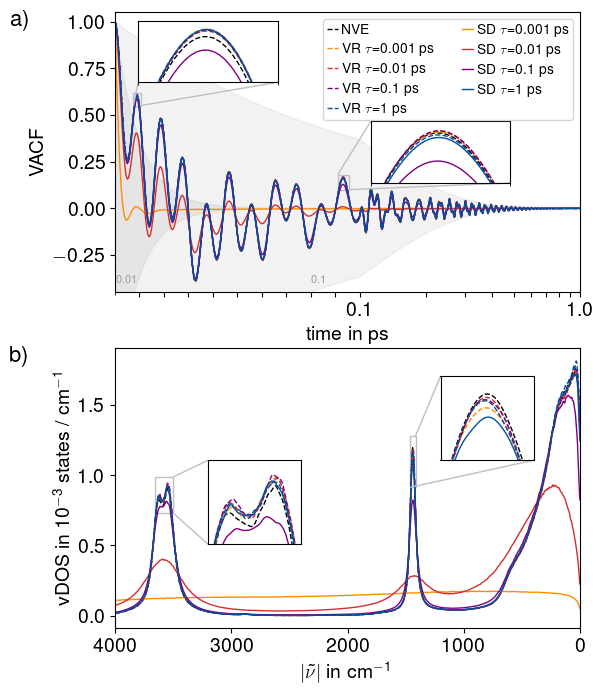

In [8]:
# --- VACF and Power Spectrum

fig, ax = plt.subplots(2, 1, figsize=(6,8))

make_plot_0(ax[0])
make_plot_1(ax[1])

plt.text(-0.05, 0.87, 'a)', va='center', size=16, transform=fig.transFigure)
plt.text(-0.05, 0.45, 'b)', va='center', size=16, transform=fig.transFigure)
plt.savefig('water_xTB_atoms_VACF.pdf', bbox_inches='tight')
plt.show()

In [9]:
# --- Combined figure


# --- VACF and Power Spectrum

n_frames = len(DATA['w0128-09965-300.0-1.nve.xTB/'].P['tcf_power'])
t_ps = np.arange(n_frames) * DATA['w0128-09965-300.0-1.nve.xTB/'].ts_fs/1000
t_ps_i = np.arange(4*n_frames-4) * DATA['w0128-09965-300.0-1.nve.xTB/'].ts_fs/1000/4

for _job in (
     'w0128-09965-300.0-%d.nve.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0001fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0010fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0100fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_1000fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_0001fs.xTB/', 
     'w0128-09965-300.0-%d.nvt_csvr_massive_0010fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_0100fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_1000fs.xTB/',  
    ):
    
    VACF = np.mean([DATA[_job%_s].P['tcf_power'] / DATA[_job%_s].P['tcf_power'][0] for _s in range(1,6)], axis=0)
    VACF_std = np.std([DATA[_job%_s].P['tcf_power'] / DATA[_job%_s].P['tcf_power'][0] for _s in range(1,6)], axis=0)
    
    _value = np.sum([DATA[_job%_s].P['tcf_power'] for _s in range(1,6)], axis=0)
    _reference = np.sum([DATA['w0128-09965-300.0-%d.nve.xTB/'%_s].P['tcf_power'] for _s in range(1,6)], axis=0)
    print(_job,  (np.sum(np.abs(_value)) - np.sum(np.abs(_reference))) / (np.sum(np.abs(_reference))))

_job = 'w0128-09965-300.0-%d.nve.xTB/'
VACF = np.mean([DATA[_job%_s].P['tcf_power'] / DATA[_job%_s].P['tcf_power'][0] for _s in range(1,6)], axis=0)



w0128-09965-300.0-%d.nve.xTB/ 0.0
w0128-09965-300.0-%d.nvt_csvr_global_0001fs.xTB/ -0.013458450155426863
w0128-09965-300.0-%d.nvt_csvr_global_0010fs.xTB/ 0.007519949419034585
w0128-09965-300.0-%d.nvt_csvr_global_0100fs.xTB/ 0.00756344986812658
w0128-09965-300.0-%d.nvt_csvr_global_1000fs.xTB/ -0.00033893027569780913
w0128-09965-300.0-%d.nvt_csvr_massive_0001fs.xTB/ -0.8938603005104451
w0128-09965-300.0-%d.nvt_csvr_massive_0010fs.xTB/ -0.5961181622038195
w0128-09965-300.0-%d.nvt_csvr_massive_0100fs.xTB/ -0.18775237443124707
w0128-09965-300.0-%d.nvt_csvr_massive_1000fs.xTB/ -0.02686929748373226


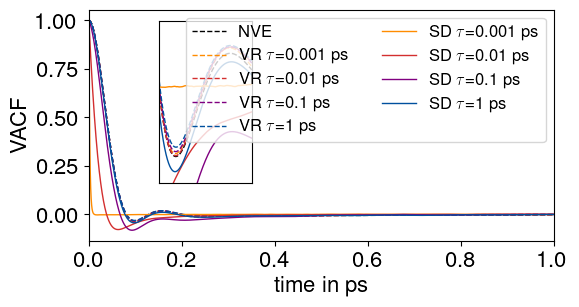

In [10]:
# --- COM VACF and DIFFUSION, MSD

n_frames = len(DATA['w0128-09965-300.0-1.nve.xTB/'].P_com['tcf_power'])
t_ps = np.arange(n_frames) * DATA['w0128-09965-300.0-1.nve.xTB/'].ts_fs/1000

fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlabel("time in ps", fontsize=16)
ax.set_ylabel("VACF",fontsize=16)
ax.tick_params(axis="both",which="major",labelsize=16)
plt.xlim(-0, 1)
# plt.xscale('symlog', linthresh=0.1)
# plt.yscale('symlog', linthresh=0.01)

# # inset plot
axins = ax.inset_axes([0.15, 0.25, 0.2, 0.7])
axins.set_xlim(0.080, 0.180)
axins.set_ylim(-0.05, 0.03)
axins.set_xticks([])
axins.set_yticks([])

# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec='0.75')


for _job, _color, _style, _label in zip(
    (
     'w0128-09965-300.0-%d.nve.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0001fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0010fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0100fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_1000fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_0001fs.xTB/', 
     'w0128-09965-300.0-%d.nvt_csvr_massive_0010fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_0100fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_1000fs.xTB/',  
    ),
    ('#000000', '#FF8C00', '#D32F2F', '#800080', '#00509E', '#FF8C00', '#D32F2F', '#800080', '#00509E'),
    ('--', '--', '--', '--', '--', '-', '-', '-', '-'),
    ('NVE', r'VR $\tau$=0.001 ps', r'VR $\tau$=0.01 ps', r'VR $\tau$=0.1 ps', r'VR $\tau$=1 ps', r'SD $\tau$=0.001 ps', r'SD $\tau$=0.01 ps', r'SD $\tau$=0.1 ps', r'SD $\tau$=1 ps'),
):
    VACF = np.mean([DATA[_job%_s].P_com['tcf_power'] / DATA[_job%_s].P_com['tcf_power'][0] for _s in range(1,6)], axis=0)
    VACF_std = np.std([DATA[_job%_s].P_com['tcf_power'] / DATA[_job%_s].P_com['tcf_power'][0] for _s in range(1,6)], axis=0)
    ax.plot(t_ps, VACF, label=_label, color=_color, linestyle=_style, linewidth=1)
    axins.plot(t_ps_i, interpolate.interp1d(t_ps, VACF, kind='cubic')(t_ps_i), label=_label, color=_color, linestyle=_style, linewidth=1)
    

# plt.tight_layout()
plt.legend(loc="upper right", fontsize=12, ncol=2)
plt.savefig('water_xTB_molecules_VACF.pdf', bbox_inches='tight')
plt.show()
# plt.close()

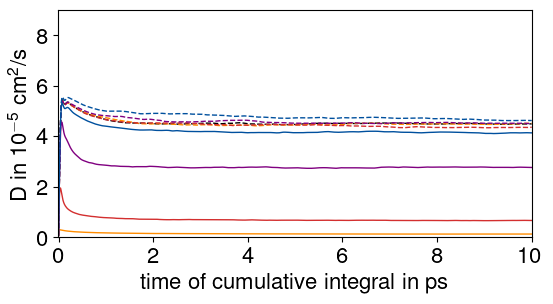

In [11]:
# --- COM VACF and DIFFUSION, MSD

n_frames = len(DATA['w0128-09965-300.0-1.nve.xTB/'].P_com['tcf_power'])
t_ps = np.arange(n_frames) * DATA['w0128-09965-300.0-1.nve.xTB/'].ts_fs/1000

fig, ax = plt.subplots(figsize=(6,3.5))
for _job, _color, _style, _label in zip(
    (
     'w0128-09965-300.0-%d.nve.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0001fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0010fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0100fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_1000fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_0001fs.xTB/', 
     'w0128-09965-300.0-%d.nvt_csvr_massive_0010fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_0100fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_1000fs.xTB/',  
    ),
    ('#000000', '#FF8C00', '#D32F2F', '#800080', '#00509E', '#FF8C00', '#D32F2F', '#800080', '#00509E'),
    ('--', '--', '--', '--', '--', '-', '-', '-', '-'),
    ('NVE', r'VR $\tau$=0.001 ps', r'VR $\tau$=0.01 ps', r'VR $\tau$=0.1 ps', r'VR $\tau$=1 ps', r'SD $\tau$=0.001 ps', r'SD $\tau$=0.01 ps', r'SD $\tau$=0.1 ps', r'SD $\tau$=1 ps'),
):
    PLOT = np.mean([np.cumsum(DATA[_job%_s].P_com['tcf_power']) * cp.constants.v_au2si**2 * DATA[_job%_s].ts_fs*cp.constants.femto / cp.constants.centi**2 for _s in range(1,6)], axis=0)
    PLOT_std = np.std([np.cumsum(DATA[_job%_s].P_com['tcf_power']) * cp.constants.v_au2si**2 * DATA[_job%_s].ts_fs*cp.constants.femto / cp.constants.centi**2 for _s in range(1,6)], axis=0)
   
    ax.plot(t_ps, PLOT/1e-5, label=_label, color=_color, linestyle=_style, linewidth=1)

ax.set_xlabel("time of cumulative integral in ps", fontsize=16)
ax.set_ylabel("D in 10$^{-5}$ cm$^2$/s",fontsize=16)
ax.tick_params(axis="both",which="major",labelsize=16)

plt.xlim(-0.01, 10)
plt.ylim(0, 9)

plt.tight_layout()
# plt.legend(loc="upper right", fontsize=12, ncol=2)
plt.savefig('water_xTB_molecules_VACF-integral.pdf', bbox_inches='tight')
plt.show()
# plt.close()

w0128-09965-300.0-%d.nve.xTB/ D in 10¯⁵ cm²/s: 4.408311 +- 0.173181
w0128-09965-300.0-%d.nvt_csvr_global_0001fs.xTB/ D in 10¯⁵ cm²/s: 4.445658 +- 0.145574
w0128-09965-300.0-%d.nvt_csvr_global_0010fs.xTB/ D in 10¯⁵ cm²/s: 4.170758 +- 0.165202
w0128-09965-300.0-%d.nvt_csvr_global_0100fs.xTB/ D in 10¯⁵ cm²/s: 4.385932 +- 0.162433
w0128-09965-300.0-%d.nvt_csvr_global_1000fs.xTB/ D in 10¯⁵ cm²/s: 4.690249 +- 0.141099
w0128-09965-300.0-%d.nvt_csvr_massive_0001fs.xTB/ D in 10¯⁵ cm²/s: 0.091019 +- 0.002361
w0128-09965-300.0-%d.nvt_csvr_massive_0010fs.xTB/ D in 10¯⁵ cm²/s: 0.601056 +- 0.018332
w0128-09965-300.0-%d.nvt_csvr_massive_0100fs.xTB/ D in 10¯⁵ cm²/s: 2.712870 +- 0.122544
w0128-09965-300.0-%d.nvt_csvr_massive_1000fs.xTB/ D in 10¯⁵ cm²/s: 3.981575 +- 0.123289


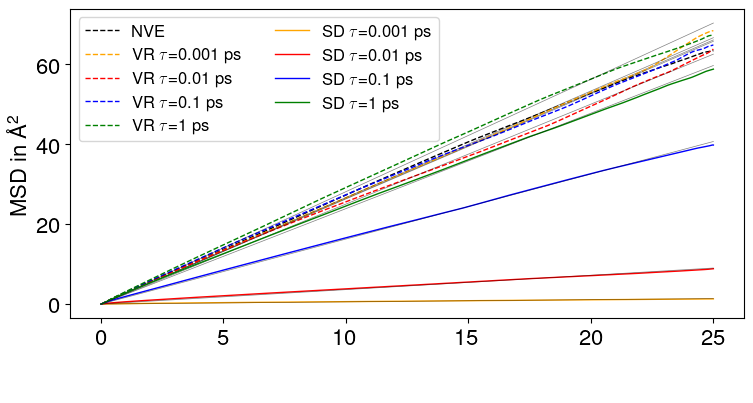

In [12]:
# --- COM VACF and DIFFUSION, MSD

n_frames = len(DATA['w0128-09965-300.0-1.nve.xTB/'].msd_aa2)
X = np.arange(n_frames) * 0.5 * msd_ds/1000
N = n_frames*25//25   # N first frames to be considered for linear regression


fig, ax = plt.subplots(figsize=(8,4.5))
for _job, _color, _style, _label in zip(
    (
     'w0128-09965-300.0-%d.nve.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0001fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0010fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0100fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_1000fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_0001fs.xTB/', 
     'w0128-09965-300.0-%d.nvt_csvr_massive_0010fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_0100fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_1000fs.xTB/',  
    ),
    ('k', 'orange', 'red', 'blue', 'green', 'orange', 'red', 'blue', 'green',),
    ('--', '--', '--', '--', '--', '-', '-', '-', '-'),
    ('NVE', r'VR $\tau$=0.001 ps', r'VR $\tau$=0.01 ps', r'VR $\tau$=0.1 ps', r'VR $\tau$=1 ps', r'SD $\tau$=0.001 ps', r'SD $\tau$=0.01 ps', r'SD $\tau$=0.1 ps', r'SD $\tau$=1 ps'),
):

    Y = np.mean([DATA[_job%_s].msd_aa2 for _s in range(1,6)], axis=0)

    m = np.mean([np.linalg.lstsq(X[:N, None], DATA[_job%_s].msd_aa2[:N], rcond=None)[0] for _s in range(1,6)], axis=0)
    m_std = np.std([np.linalg.lstsq(X[:N, None], DATA[_job%_s].msd_aa2[:N], rcond=None)[0] for _s in range(1,6)], axis=0) / np.sqrt(5)
    
    # --- compute D from MSD (first 10ps)
    # Y = DATA[_job].msd_aa2
    # m, residuals, rank, s = np.linalg.lstsq(X[:N, None], Y[:N], rcond=None)
    D_cm2s_1 = m[0] * 1.E-16 / cp.constants.pico / 6
    D_cm2s_1_std = m_std[0] * 1.E-16 / cp.constants.pico / 6
    # sXX = np.sum((X[:N] - np.mean(X[:N]))**2)
    
    # stderr = np.sqrt(residuals[0]/(N-2))  / np.sqrt(sXX)  # not sure if this is valid for linear regression without intercept

    ax.plot(X, Y, label=_label, color=_color, linestyle=_style, linewidth=1)
    plt.plot(X, m*X, color='k', ls='-', lw=0.5, alpha=0.5)
    # if 'nve' in _job: 
        # plt.fill_between(X, (m + m_std)*X, (m - m_std)*X, alpha=0.2, color='0.5')

    # stderr *= 1.E-16 / cp.constants.pico / 6
    print(r'%s D in 10¯⁵ cm²/s: %f +- %f' % (_job, D_cm2s_1*1.E5, D_cm2s_1_std*1.E5))
    




ax.set_xlabel(r'$$\tau$$ in ps', fontsize=16)
ax.set_ylabel(r'MSD in \AA{}$^2$', fontsize=16)
ax.tick_params(axis="both",which="major",labelsize=16)

# plt.xlim(-0.01, 10)
# plt.ylim(0, 8.E-5)

plt.tight_layout()
plt.legend(loc="upper left", fontsize=12, ncol=2)
# plt.savefig('water_xTB_molecules_MSD.pdf', bbox_inches='tight')
plt.show()
# plt.close()

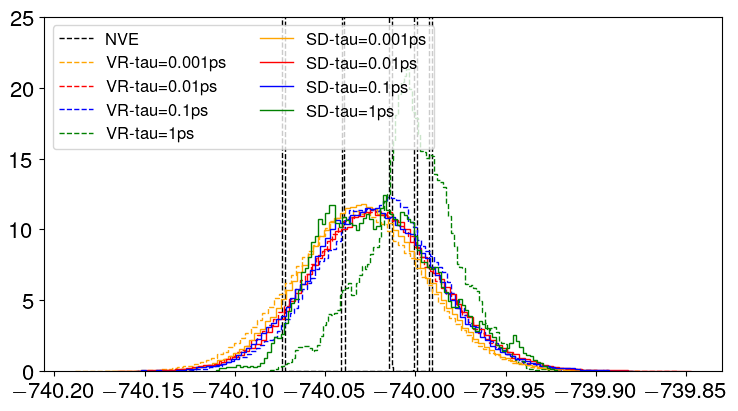

In [13]:
# --- E dist

from scipy.ndimage import gaussian_filter1d
# n_frames = len(DATA['w0128-09965-300.0-1.nve.xTB/'].msd_aa2)
# X = np.arange(n_frames) * 0.5 * msd_ds/1000
# N = n_frames*25//25   # N first frames to be considered for linear regression
DIR = '/home/jaehnigen/trajectories/water/new_tcf_with_thermostat_nobackup/'


def extract_Etot(folder):
    ENER = np.loadtxt(DIR + folder + 'md-1.ener').T
    return ENER[2] + ENER[4]
    
fig, ax = plt.subplots(figsize=(8,4.5))
for _job, _color, _style, _label in zip(
    (
     'w0128-09965-300.0-%d.nve.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0001fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0010fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_0100fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_global_1000fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_0001fs.xTB/', 
     'w0128-09965-300.0-%d.nvt_csvr_massive_0010fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_0100fs.xTB/',
     'w0128-09965-300.0-%d.nvt_csvr_massive_1000fs.xTB/',  
    ),
    ('k', 'orange', 'red', 'blue', 'green', 'orange', 'red', 'blue', 'green',),
    ('--', '--', '--', '--', '--', '-', '-', '-', '-'),
    ('NVE', r'VR-tau=0.001ps', r'VR-tau=0.01ps', r'VR-tau=0.1ps', r'VR-tau=1ps', r'SD-tau=0.001ps', r'SD-tau=0.01ps', r'SD-tau=0.1ps', r'SD-tau=1ps'),
):

    Etot = np.concatenate([extract_Etot(_job%_i) for _i in range(1,6)], axis=0)
    # SIGNAL -= np.mean(SIGNAL)
    np.savetxt('E_tot-'+_label+'.dat', Etot)
    counts, bins = np.histogram(Etot, bins=100, density=True)
    # counts /= np.amax(counts) # for visualization purposes
    plt.stairs(gaussian_filter1d(counts, 0.1), bins, color=_color, linestyle=_style, label=_label)


ax.tick_params(axis="both",which="major",labelsize=16)


plt.tight_layout()
plt.legend(loc="upper left", fontsize=12, ncol=2)
plt.ylim(0, 25)
plt.show()
# plt.close()